<a href="https://colab.research.google.com/github/wildtulipan/Acetycholine-Striatal-Dynamics/blob/main/FiberPhotometry_Acetylcholine_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acetylcholine Photometry

Este codigo n¿aldsldsfldsal

## Set up
Run this section before running everythin else

In [58]:
# @title Mount Google Drive
import os
from google.colab import drive
drive.mount('/content/drive')
notebook_path = '/content/drive/MyDrive/Research/Striatum_Acetylcholine'
print("Notebook is in:", notebook_path)
os.chdir(notebook_path) # Set it as the working directory
print("Working directory set to notebook's location.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Notebook is in: /content/drive/MyDrive/Research/Striatum_Acetylcholine
Working directory set to notebook's location.


In [59]:
#@title Load Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import linregress
from tqdm import tqdm
from scipy import stats
from scipy.signal import welch, butter, filtfilt, hilbert



In [60]:
#@title Helper Functions
def parse_photometry_data(path):
    """
    Parses fiber photometry data from a directory structure and organizes it into a nested dictionary.
    The function expects folders with names containing animal ID, cell type, experiment, and session information
    in a specific format (10 underscore-separated parts). Each folder should contain:
    - Events.csv
    - Fluorescence-unaligned.csv
    - Fluorescence.csv
    - Outputs.csv

    Args:
        path (str): Path to the root directory containing photometry data folders

    Returns:
        dict: {animal_id: {'cell_type': str, experiment: {session: {data_files...}}}
                      where data_files includes all CSV contents as DataFrames
    Raises:
        SystemExit: If the specified directory doesn't exist
    """

    photometry_data_dict = {}
    photomerty_path = os.path.join(path, 'Fiber_Photometry')

    # Check if path exists
    if not os.path.exists(path):
        print("Error: Directory doesn't exist")
        exit()

    print("\nFound folders:")
    print("ID\tCell\tExperiment\tSession")  # \t makes tab spacing
    print("-" * 40)

    # Go through each item in the folder
    for folder in os.listdir(photomerty_path):
        full_path = os.path.join(photomerty_path, folder)

        # Only process if it's a folder
        if os.path.isdir(full_path):
            parts = folder.split('_')

            # Check if folder name has enough parts
            if len(parts) == 10:
                # Get the parts we care about
                animal_id = int(parts[6])
                cell_type = str(parts[7])
                experiment = str(parts[8])
                session = int(parts[9])

                # Print the info with tab spacing
                print(f"{animal_id}\t{cell_type}\t{experiment}\t\t{session}")

                # Extract the files
                Events = pd.read_csv(os.path.join(full_path, 'Events.csv'))
                Fluorescence_unaligned = pd.read_csv(os.path.join(full_path, 'Fluorescence-unaligned.csv'))
                Fluorescence = pd.read_csv(os.path.join(full_path, 'Fluorescence.csv'))
                Outputs = pd.read_csv(os.path.join(full_path, 'Outputs.csv'))

                # Set up the data format
                if animal_id not in photometry_data_dict:
                    photometry_data_dict[animal_id] = {}
                    photometry_data_dict[animal_id]['cell_type'] = cell_type
                if experiment not in photometry_data_dict[animal_id]:
                    photometry_data_dict[animal_id][experiment] = {}
                if session not in photometry_data_dict[animal_id][experiment]:
                    photometry_data_dict[animal_id][experiment][session] = {
                        'Events': Events,
                        'Fluorescence-unaligned': Fluorescence_unaligned,
                        'Fluorescence': Fluorescence,
                        'Outputs': Outputs
                    }

    return photometry_data_dict


def bandpass_filter_signal(signal, lowcut, highcut, fs, order=4):
    """
    Apply a zero-phase Butterworth bandpass filter to a signal.

    Args:
        signal (np.ndarray): Input signal (1D array)
        lowcut (float): Lower cutoff frequency (Hz)
        highcut (float): Upper cutoff frequency (Hz)
        fs (float): Sampling rate (Hz)
        order (int): Filter order

    Returns:
        np.ndarray: Filtered signal
    """
    # Normalize frequencies by Nyquist (fs/2)
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')

    # Apply zero-phase filtering (filtfilt avoids phase distortion)
    filtered_signal = filtfilt(b, a, signal)

    return filtered_signal

def process_photometry_data(photometry_data_dict, lowcut=0.3, highcut=5, fs=15):
    """
    Processes photometry data by:
    1. Aligning 470nm and 410nm signals
    2. Applying bandpass filtering
    3. Performing motion correction via linear regression
    4. Storing all results in the input dictionary

    Args:
        photometry_data_dict (dict): Nested photometry data structure
        lowcut (float): Low cutoff frequency for bandpass filter
        highcut (float): High cutoff frequency for bandpass filter
        fs (float): Sampling rate in Hz

    Returns:
        dict: Modified photometry_data_dict with added processed data
    """

    # Initialize progress bar (optional)
    total_sessions = sum(len(exp) for animal in photometry_data_dict.values()
                        for exp in animal.values() if isinstance(exp, dict))

    with tqdm(total=total_sessions, desc="Processing sessions") as pbar:
        for animal_id, animal_data in photometry_data_dict.items():
            cell_type = animal_data['cell_type']

            for experiment_name, sessions in animal_data.items():
                if experiment_name == 'cell_type':
                    continue

                for session_num, session_data in sessions.items():
                    # Update progress bar
                    pbar.set_postfix({
                        'Animal': animal_id,
                        'Experiment': experiment_name,
                        'Session': session_num
                    })
                    pbar.update(1)

                    # Get raw fluorescence data
                    fluo_unaligned = session_data['Fluorescence-unaligned']

                    try:
                        # Extract and align signals
                        fluorescence_470 = np.array(fluo_unaligned['Channel1'][fluo_unaligned['Lights'] == 470])
                        fluorescence_410 = np.array(fluo_unaligned['Channel1'][fluo_unaligned['Lights'] == 410])
                        min_length = min(len(fluorescence_470), len(fluorescence_410))
                        fluorescence_470 = fluorescence_470[:min_length]
                        fluorescence_410 = fluorescence_410[:min_length]

                        # Filter signals
                        fluorescence_470_filt = bandpass_filter_signal(
                          fluorescence_470, lowcut=lowcut, highcut=highcut, fs=fs
                        )
                        fluorescence_410_filt = bandpass_filter_signal(
                          fluorescence_410, lowcut=lowcut, highcut=highcut, fs=fs
                        )

                        # Motion correction
                        slope, intercept, r_value, p_value, std_err = linregress(
                            x=fluorescence_410_filt,
                            y=fluorescence_470_filt
                        )
                        fluorescence_470_est_motion = intercept + slope * fluorescence_410_filt
                        fluorescence_470_corrected = fluorescence_470_filt - fluorescence_470_est_motion

                        # Add the envelope data
                        envelope = np.abs(hilbert(fluorescence_470_corrected))

                        # Store all processed data
                        session_data['processed'] = {
                            'corrected': fluorescence_470_corrected,
                            'est_motion': fluorescence_470_est_motion,
                            '470_filt': fluorescence_470_filt,
                            '410_filt': fluorescence_410_filt,
                            '470_raw': fluorescence_470,
                            '410_raw': fluorescence_410,
                            'envelope': envelope,
                            'regression_params': {
                                'slope': slope,
                                'intercept': intercept,
                                'r_value': r_value,
                                'p_value': p_value,
                                'std_err': std_err
                            }
                        }

                    except Exception as e:
                        print(f"Error processing {animal_id}/{experiment_name}/{session_num}: {str(e)}")
                        continue

    return photometry_data_dict

def extract_signal_epochs(photometry_data_dict, path, pre_seconds=2, post_seconds=6):
    """
    Extract signal epochs around tone events from photometry data.

    Parameters:
    -----------
    photometry_data_dict : dict
        Dictionary containing photometry data organized by animal_id, experiment_name, and session_num
    path : str
        Base path to the data directory containing the 'Behavior' subdirectory
    pre_seconds : float, default=2
        Seconds to extract before each event
    post_seconds : float, default=6
        Seconds to extract after each event

    Returns:
    --------
    dict
        Dictionary with the same structure as input but with epochs, stim_map, and trial_counts added
        to each session
    """
    # Define constants
    sampling_rate = 15  # Hz
    behavior_path = os.path.join(path, 'Behavior')

    # Define the mapping of flags to tone types
    tone_mapping = {
        11: 1, 21: 1,  # Tone type 1
        12: 2, 22: 2,  # Tone type 2
        13: 3, 23: 3,  # Tone type 3
        14: 4, 24: 4   # Tone type 4
    }

    # Define tone flags
    banderas_tonos = [11, 12, 13, 14, 21, 22, 23, 24]

    # Count total sessions for progress bar
    total_sessions = sum(
        len(sessions) for animal_data in photometry_data_dict.values()
        for exp_name, sessions in animal_data.items() if exp_name != 'cell_type'
    )

    # Create progress bar
    pbar = tqdm(total=total_sessions, desc="Processing sessions")

    # Loop through the photometry recordings
    for animal_id, animal_data in photometry_data_dict.items():
        cell_type = animal_data.get('cell_type', '')

        for experiment_name, sessions in animal_data.items():
            if experiment_name == 'cell_type':
                continue

            for session_num, session_data in sessions.items():
                # Update progress bar description
                pbar.set_description(f"Animal {animal_id} | Exp {experiment_name} | Session {session_num}")

                # Find behavioral data for this session
                session_behavior_file = None

                for behavior_file in os.listdir(behavior_path):
                    parts = behavior_file.split('_')
                    if len(parts) == 7:
                        if str(parts[0]) == cell_type and int(parts[1]) == animal_id and \
                           str(parts[2]) == experiment_name and int(parts[3]) == session_num:
                            session_behavior_file = behavior_file
                            break

                if not session_behavior_file:
                    pbar.update(1)  # Update progress even for skipped sessions
                    continue

                # Load and parse behavioral data
                behavior_file_path = os.path.join(behavior_path, session_behavior_file)
                data = []

                with open(behavior_file_path, 'r') as fid:
                    raw = fid.readlines()

                for i in range(1, len(raw)):
                    line = raw[i].strip()
                    if not line:
                        continue

                    parts = line.split('.')
                    if len(parts) >= 4:
                        try:
                            timestamp = float(parts[2])
                            flag = float(parts[3])
                            data.append([timestamp, flag])
                        except (ValueError, IndexError):
                            continue

                if not data:
                    pbar.update(1)
                    continue

                data = np.array(data)

                # Extract tone events
                tone_data = data[np.isin(data[:, 1], banderas_tonos)]

                # Process tone events
                order, times, tone_types = [], [], []

                for i in range(len(tone_data)):
                    flag = int(tone_data[i, 1])
                    time = tone_data[i, 0]

                    if flag in tone_mapping:
                        tone_type = tone_mapping[flag]
                        order.append(i + 1)
                        times.append(time)
                        tone_types.append(tone_type)

                # Create and process tone DataFrame
                tone_df = pd.DataFrame({
                    'order': order,
                    'time': times,
                    'tone_type': tone_types
                }).sort_values('time').reset_index(drop=True)

                tone_df['order'] = range(1, len(tone_df) + 1)

                # Get timestamps from photometry events
                events_df = session_data['Events']
                stim_df = events_df[(events_df['Name'] == 'Input1') &
                                    (events_df['State'] == 0)].reset_index()

                # Get the photometry samples
                samples_df = session_data["Fluorescence-unaligned"]
                samples_470 = samples_df[samples_df['Lights'] == 470].reset_index()

                # Skip if dataframes have different lengths
                if len(tone_df) != len(stim_df):
                    pbar.update(1)
                    continue

                # Combine dataframes and calculate sample indices
                combined_df = pd.DataFrame({
                    'order': tone_df['order'],
                    'time': tone_df['time'],
                    'tone_type': tone_df['tone_type'],
                    'TimeStamp': stim_df['TimeStamp']
                })

                if pd.api.types.is_datetime64_any_dtype(combined_df['TimeStamp']):
                    ts1 = combined_df['TimeStamp'].view('int64')
                else:
                    ts1 = combined_df['TimeStamp']

                if pd.api.types.is_datetime64_any_dtype(samples_470['TimeStamp']):
                    ts2 = samples_470['TimeStamp'].view('int64')
                else:
                    ts2 = samples_470['TimeStamp']

                # Initialize list to store closest indices
                closest_indices = []

                # For each timestamp in the first DataFrame
                for ts in ts1:
                    # Calculate absolute differences between this timestamp and all timestamps in the second DataFrame
                    abs_diffs = np.abs(ts2 - ts)

                    # Find the index with the minimum difference
                    closest_idx = abs_diffs.argmin()

                    # Add to our result list
                    closest_indices.append(closest_idx)

                # Calculate sample for each tone
                combined_df['sample'] = closest_indices

                # Create epoch extraction parameters
                pre_samples = int(pre_seconds * sampling_rate)
                post_samples = int(post_seconds * sampling_rate)
                epoch_length = pre_samples + post_samples

                # Get unique stimulus types
                stim_types = sorted(combined_df['tone_type'].unique())
                n_stim_types = len(stim_types)
                stim_type_to_idx = {stim: idx for idx, stim in enumerate(stim_types)}

                # Count trials per stimulus
                trials_per_stim = combined_df.groupby('tone_type').size()
                max_trials = trials_per_stim.max()

                # Initialize epoch matrix and counters
                epochs = np.full((max_trials, epoch_length, n_stim_types), np.nan)
                trial_counters = {stim: 0 for stim in stim_types}

                # Get the signal data
                signal = session_data["processed"]["corrected"]
                #signal = (signal-np.mean(signal))/np.std(signal)

                # Extract epochs for each stimulus type
                for stim_type in stim_types:
                    stim_idx = stim_type_to_idx[stim_type]
                    stim_events = combined_df[combined_df['tone_type'] == stim_type]

                    for _, event in stim_events.iterrows():
                        sample_idx = event['sample']
                        trial_idx = trial_counters[stim_type]

                        start_idx = sample_idx - pre_samples
                        end_idx = sample_idx + post_samples

                        if start_idx >= 0 and end_idx < len(signal):
                            epoch = signal[int(start_idx):int(end_idx)]
                            epoch = (epoch - np.mean(epoch[0:pre_samples])) / np.std(epoch[0:pre_samples])
                            epochs[trial_idx, :, stim_idx] = epoch
                            trial_counters[stim_type] += 1

                # Store only the requested variables in session data
                session_data['epochs'] = epochs
                session_data['stim_map'] = stim_type_to_idx
                session_data['trial_counts'] = trial_counters

                # Update progress bar
                pbar.update(1)

    # Close progress bar
    pbar.close()

    return photometry_data_dict

# Function to combine epochs from multiple sessions
def combine_sessions(session_info_list, photometry_data_dict):
    """
    Combine epochs data from multiple sessions.

    Parameters:
    -----------
    session_info_list : list of dicts
        List of dictionaries where each dict contains keys:
        - animal_id: ID of the animal
        - experiment_name: Name of the experiment (e.g., "AQ", "UP", "UR")
        - session_num: Session number

    photometry_data_dict : dict
        Dictionary containing all photometry data organized by animal_id, experiment_name, and session_num

    Returns:
    --------
    combined_epochs : ndarray
        Combined epochs data from all specified sessions
    time : ndarray
        Time vector (assuming all sessions use the same time vector)
    """
    epochs_list = []
    time = None

    for session_info in session_info_list:
        animal_id = session_info['animal_id']
        experiment_name = session_info['experiment_name']
        session_num = session_info['session_num']

        # Get session data
        session_data = photometry_data_dict[animal_id][experiment_name][session_num]

        # Extract epochs data
        epochs = session_data['epochs']
        epochs_list.append(epochs)

        # Get time vector (only need to do this once if all sessions use the same time vector)
        if time is None:
            time = np.linspace(-2, 6, 15*8)

    # Combine all epochs data
    combined_epochs = np.concatenate(epochs_list, axis=0)

    return combined_epochs, time

def AUROC(A, B):
    """
    Performs an AUROC analysis for two sets of data using
    gaussian approximation.

    Parameters:
    - A: NumPy 1-D array or list, the first set of data.
    - B: NumPy 1-D array or list, the second set of data.

    Returns:
    - AUROC value between 0 and 1.
    """
    # Extracting the parameters for gaussian approximation
    A_mu, A_std = np.mean(A), np.std(A)
    B_mu, B_std = np.mean(B), np.std(B)

    # For Gaussian distributions, AUROC can be calculated analytically
    denominator = np.sqrt(A_std**2 + B_std**2)
    if denominator == 0:  # Handle the case of zero variance
        return 1.0 if B_mu > A_mu else 0.0

    z = (B_mu - A_mu) / denominator

    # Calculate AUROC using the CDF of the standard normal distribution
    auroc = stats.norm.cdf(z)
    return auroc

In [61]:
from os.path import samefile
#@title Data Loader
path = "/content/drive/MyDrive/Research/Striatum_Acetylcholine/Data"
photometry_data_dict = parse_photometry_data(path)
photometry_data_dict = process_photometry_data(photometry_data_dict)
photometry_data_dict = extract_signal_epochs(photometry_data_dict, path)



Found folders:
ID	Cell	Experiment	Session
----------------------------------------
8620	A2a	UR		1
8620	A2a	AQ		1
8620	A2a	AQ		9
8620	A2a	AQ		10
8620	A2a	UP		1
8620	A2a	UP		3
8620	A2a	UP		2
8619	A2a	AQ		9
8619	A2a	UP		1
8641	D1	AQ		9
8915	A2a	AQ		7
8912	A2a	AQ		7


Processing sessions: 100%|██████████| 12/12 [00:00<00:00, 58.59it/s, Animal=8912, Experiment=AQ, Session=7]
Animal 8912 | Exp AQ | Session 7: 100%|██████████| 12/12 [00:03<00:00,  3.23it/s]


## Analysis

(-2.0, 6.0)

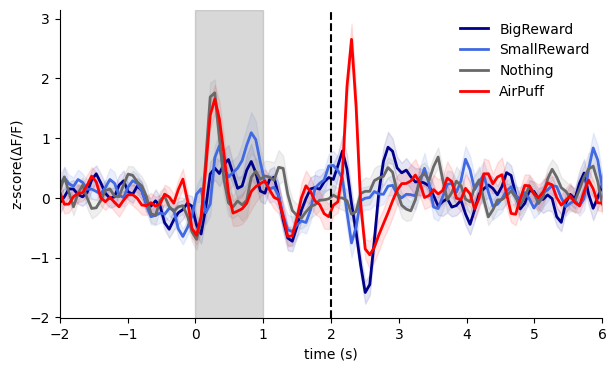

In [62]:
#@title Plot Fiber Photomery Data (Single Experiment)
# Example usage:
animal_id = 8915
experiment_name = 'AQ'
session_num = 7
session = photometry_data_dict[animal_id][experiment_name][session_num]
epoch = session['epochs']

# Calculate mean and standard error
mean_epochs = np.mean(epoch, axis=0)
set_epochs = np.std(epoch, axis=0) / np.sqrt(epoch.shape[0])
time = np.linspace(-2, 6, 15*8)
# Plot combined experiments
colors = ["darkblue","royalblue","dimgray","red"]
condition_names = ["BigReward", "SmallReward", "Nothing", "AirPuff"]

plt.figure(figsize=(7, 4))
for stim in range(4):
  plt.plot(time,mean_epochs[:, stim],color=colors[stim],linewidth=2,label=condition_names[stim])
  plt.fill_between(time, mean_epochs[:, stim] - set_epochs[:, stim], mean_epochs[:, stim] + set_epochs[:, stim], alpha=0.1, color=colors[stim])
# Customize plot
plt.gca().spines['top'].set_visible(False)    # Remove top spine
plt.gca().spines['right'].set_visible(False)  # Remove right spine
plt.xlabel("time (s)")
plt.ylabel("z-score(ΔF/F)")
plt.axvline(2,color="black",linestyle="--")
plt.axvspan(0, 1, alpha=0.3, color='gray')
plt.legend(frameon=False)
plt.xlim([-2,6])


Combined epochs shape: (200, 120, 4)


(-2.0, 6.0)

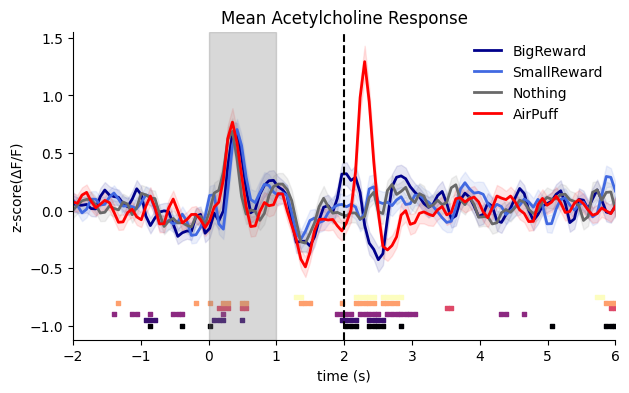

In [47]:
#@title Plot Fiber Photomery Data
# Example usage:
sessions_to_combine = [
    {'animal_id': 8620, 'experiment_name': 'AQ', 'session_num': 9},
    {'animal_id': 8619, 'experiment_name': 'AQ', 'session_num': 9},
    {'animal_id': 8641, 'experiment_name': 'AQ', 'session_num': 9},
    {'animal_id': 8912, 'experiment_name': 'AQ', 'session_num': 7},
    {'animal_id': 8915, 'experiment_name': 'AQ', 'session_num': 7}
]
time_vector = np.linspace(-2, 6, 15*8)  # Time from -2 to 6 seconds

# Combine the sessions
epochs_combined, time = combine_sessions(sessions_to_combine, photometry_data_dict)

# Now you can use epochs_combined for further analysis or plotting
print(f"Combined epochs shape: {epochs_combined.shape}")

# Calculate mean and standard error
mean_epochs = np.mean(epochs_combined, axis=0)
set_epochs = np.std(epochs_combined, axis=0) / np.sqrt(epochs_combined.shape[0])

# Plot combined experiments
colors = ["darkblue","royalblue","dimgray","red"]
condition_names = ["BigReward", "SmallReward", "Nothing", "AirPuff"]
plt.figure(figsize=(7, 4))
for stim in range(4):
  plt.plot(time,mean_epochs[:, stim],color=colors[stim],linewidth=2,label=condition_names[stim])
  plt.fill_between(time, mean_epochs[:, stim] - set_epochs[:, stim], mean_epochs[:, stim] + set_epochs[:, stim], alpha=0.1, color=colors[stim])
# Customize plot
colors = [magma(i/5) for i in range(6)]
for i in range(AUROCs.shape[0]):
  AUROC_timeseries = AUROCs[i,:]
  over_treshold = np.where((AUROC_timeseries > threshold) | (AUROC_timeseries < (1-threshold)))[0]
  mask_x = time_vector[over_treshold]
  mask_y = np.full(len(over_treshold), -1+(i*0.05))
  plt.scatter(mask_x,mask_y,color=colors[i%len(colors)],marker="s",s=10)
plt.gca().spines['top'].set_visible(False)    # Remove top spine
plt.gca().spines['right'].set_visible(False)  # Remove right spine
plt.xlabel("time (s)")
plt.title("Mean Acetylcholine Response")
plt.ylabel("z-score(ΔF/F)")
plt.axvline(2,color="black",linestyle="--")
plt.legend(frameon=False)
plt.axvspan(0, 1, alpha=0.3, color='gray')
plt.xlim([-2,6])

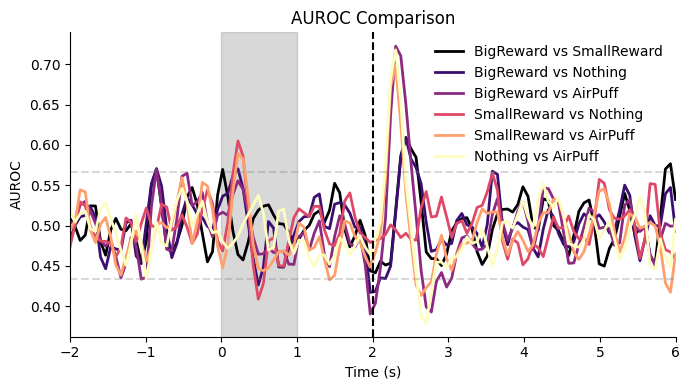

In [48]:
#@title Multiple Comparisons (AUROC)
import numpy as np
import matplotlib.pyplot as plt

# Define condition names and time vector
condition_names = ["BigReward", "SmallReward", "Nothing", "AirPuff"]
time_vector = np.linspace(-2, 6, 15*8)  # Time from -2 to 6 seconds

# Calculate AUROC comparison matrices for all time points
n_time_points = epochs_combined.shape[1]
n_conditions = epochs_combined.shape[2]
comparison_matrices = np.zeros((n_time_points, n_conditions, n_conditions))

for t in range(n_time_points):
    time_bin_data = epochs_combined[:, t, :]

    for i in range(n_conditions):
        for j in range(n_conditions):
            data_i = time_bin_data[:, i]
            data_j = time_bin_data[:, j]
            comparison_matrices[t, i, j] = AUROC(data_i, data_j)

# Plot the comparisons
plt.figure(figsize=(7, 4))
from matplotlib.cm import magma
# Generate 6 colors evenly spaced from the viridis colormap
colors = [magma(i/5) for i in range(6)]
plotted_pairs = set()
color_index = 0
basal_comparation = []
AUROCs = []
AUROCs_labels = []

for i in range(n_conditions):
    for j in range(n_conditions):
        # Skip self-comparisons and duplicates
        if i == j or (j, i) in plotted_pairs:
            continue

        # Add this pair to tracking set and create the label
        plotted_pairs.add((i, j))
        label = f"{condition_names[i]} vs {condition_names[j]}"
        basal_comparation = comparison_matrices[0:20, i, j]
        AUROCs.append(comparison_matrices[:, i, j])
        AUROCs_labels.append(label)

        # Plot the data
        plt.plot(time_vector, comparison_matrices[:, i, j],
                color=colors[color_index % len(colors)],
                label=label,
                linewidth=2)

        color_index += 1

# Calculate the threshold
mean_basal_comparation = np.mean(basal_comparation)
std_basal_comparation = np.std(basal_comparation)
threshold = mean_basal_comparation + 3*std_basal_comparation
AUROCs = np.array(AUROCs)

# Add labels and finishing touches
plt.xlabel('Time (s)')
plt.title('AUROC Comparison')
plt.ylabel('AUROC')
plt.gca().spines['top'].set_visible(False)
plt.axhline(y=threshold, color='gray', linestyle='--', alpha=0.3)
plt.axhline(y=1-threshold, color='gray', linestyle='--', alpha=0.3)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon=False)
plt.axvline(2,color="black",linestyle="--")
plt.axvspan(0, 1, alpha=0.3, color='gray')
plt.xlim([-2,6])
plt.tight_layout()
plt.show()

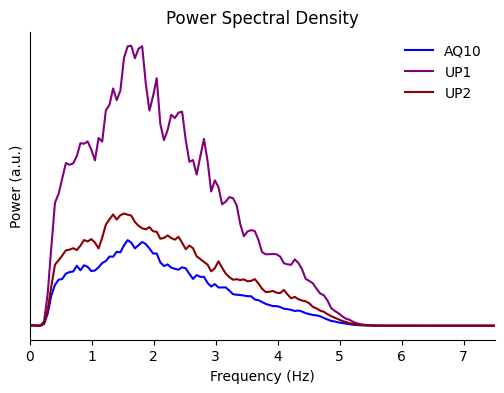

In [57]:
#@title PSD comparation
animal_id = 8620
fs = 15  # Sampling frequency
lowcut = 0.5  # Low cutoff frequency in Hz
highcut = 4.0  # High cutoff frequency in Hz

# Function to extract signal for a given experiment and session
def extract_signal(animal_id, experiment, session):
    session_data = photometry_data_dict[animal_id][experiment][session]
    return session_data['processed']["corrected"]

# Extract all signals
signals = {
    'AQ9': extract_signal(animal_id, 'AQ', 9),
    'AQ10': extract_signal(animal_id, 'AQ', 10),
    'UP1': extract_signal(animal_id, 'UP', 1),
    'UP2': extract_signal(animal_id, 'UP', 2),
}

# Function to calculate PSD
def calculate_psd(signal, fs):
    return welch(signal, fs, window="hamming")

# Calculate PSD for all signals
psd_data = {}
for label, signal in signals.items():
    frequencies, psd = calculate_psd(signal, fs)
    psd_data[label] = (frequencies, psd)

# Plot settings
colors = {
    'AQ9': 'blue',
    'AQ10': 'blue',
    'UP1': 'purple',
    'UP2': 'darkred'
}

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Plot PSDs (AQ9 is commented out in the original code)
for label, (freq, psd) in psd_data.items():
    if label != 'AQ9':  # Skip AQ9 as in the original
        ax.plot(freq, psd, color=colors[label], label=label)

# Set plot properties
ax.set_xlim([0, psd_data['AQ9'][0][-1]])
ax.set_title('Power Spectral Density')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (a.u.)')
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks([])
plt.show()

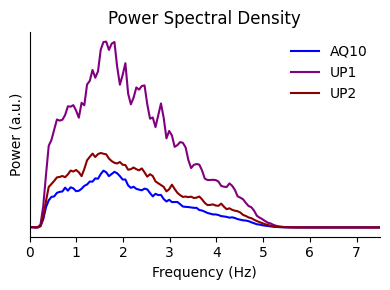

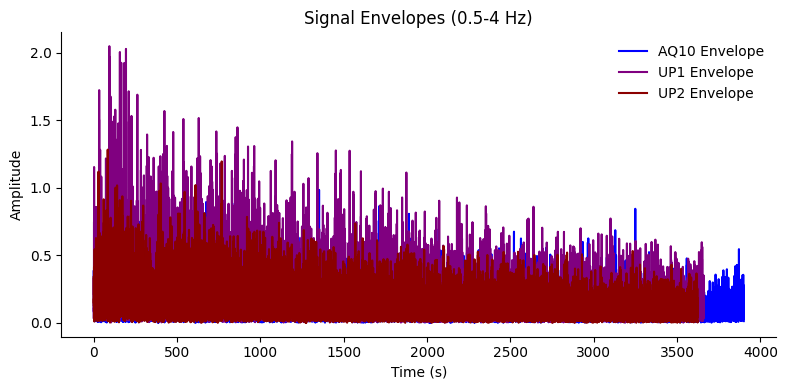

In [53]:
import numpy as np
from scipy.signal import welch, butter, filtfilt, hilbert
import matplotlib.pyplot as plt

# Parameters
animal_id = 8620
fs = 15  # Sampling frequency
lowcut = 0.5  # Low cutoff frequency in Hz
highcut = 4.0  # High cutoff frequency in Hz

# Function to extract signal for a given experiment and session
def extract_signal(animal_id, experiment, session):
    session_data = photometry_data_dict[animal_id][experiment][session]
    return session_data['processed']["corrected"]

# Extract all signals
signals = {
    'AQ9': extract_signal(animal_id, 'AQ', 9),
    'AQ10': extract_signal(animal_id, 'AQ', 10),
    'UP1': extract_signal(animal_id, 'UP', 1),
    'UP2': extract_signal(animal_id, 'UP', 2)
}

# Function to calculate PSD
def calculate_psd(signal, fs):
    return welch(signal, fs, window="hamming")

# Function to apply bandpass filter
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Function to calculate signal envelope
def calculate_envelope(signal):
    analytic_signal = hilbert(signal)
    return np.abs(analytic_signal)

# Calculate PSD for all signals
psd_data = {}
for label, signal in signals.items():
    frequencies, psd = calculate_psd(signal, fs)
    psd_data[label] = (frequencies, psd)

# Calculate filtered signals and their envelopes
filtered_signals = {}
envelopes = {}
for label, signal in signals.items():
    filtered = bandpass_filter(signal, lowcut, highcut, fs)
    filtered_signals[label] = filtered
    envelopes[label] = calculate_envelope(filtered)

# Plot settings
colors = {
    'AQ9': 'blue',
    'AQ10': 'blue',
    'UP1': 'purple',
    'UP2': 'darkred'
}

# Create time vector
max_length = max(len(signal) for signal in signals.values())
t = np.arange(0, max_length/fs, 1/fs)

# 1. Plot Power Spectral Density
fig1, ax1 = plt.subplots(figsize=(4, 3))
for label, (freq, psd) in psd_data.items():
    if label != 'AQ9':  # Skip AQ9 as in the original
        ax1.plot(freq, psd, color=colors[label], label=label)

# Set PSD plot properties
ax1.set_xlim([0, psd_data['AQ9'][0][-1]])
ax1.set_title('Power Spectral Density')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Power (a.u.)')
ax1.legend(frameon=False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.yticks([])
plt.tight_layout()
plt.show()

# 2. Plot Signal Envelopes
fig2, ax2 = plt.subplots(figsize=(8, 4))
for label, envelope in envelopes.items():
    if label != 'AQ9':  # Skip AQ9 to match the original pattern
        time_vec = t[:len(envelope)]  # Adjust time vector to match signal length
        ax2.plot(time_vec, envelope, color=colors[label], label=f"{label} Envelope")

# Set envelope plot properties
ax2.set_title('Signal Envelopes (0.5-4 Hz)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.legend(frameon=False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

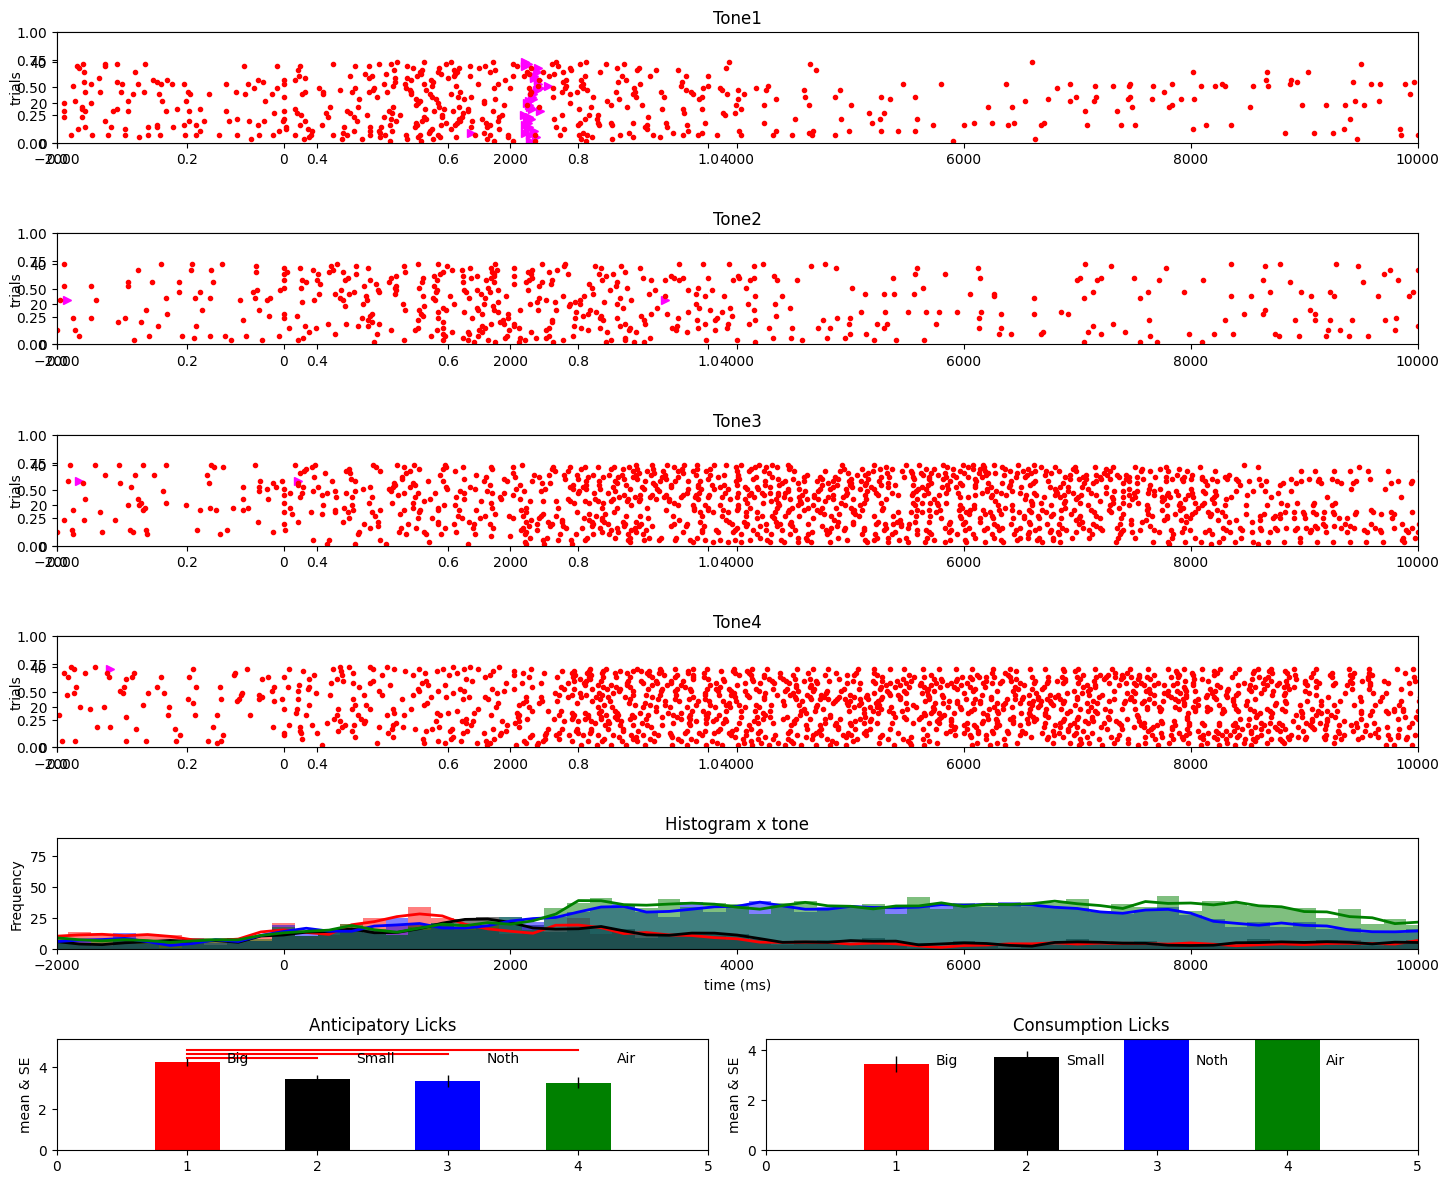

In [ ]:
#@title Single Session Behavioral Analysis
"""
Plot_Licks_Individual_DV_Python.py
Python conversion of Plot_Licks_Individual_DV_Antonio.m
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.signal import savgol_filter

# Configuration parameters
licks_raw = False     # False for first touch of tongue (red), True for raw data (black)
filename_arduino = '/content/drive/MyDrive/Research/Striatum_Acetylcholine/Data/Behavior/A2a_8914_UP_3__e_165533.txt'
star_window = 500       # time (ms) beginning of anticipatory licks
end_window = 2000     # time (ms) end of anticipatory licks
star_window_consum = 2000  # time (ms) beginning of consumption licks
end_window_consum = 4000   # time (ms) end of consumption licks

# Load the file ----------------------------------------------------------------
raw = []
with open(filename_arduino, 'r') as fid:
    raw = fid.readlines()

# Split information and create data array (time in ms, event flags)
data = []
for i in range(1, len(raw)):
    line = raw[i].strip()
    if not line:  # Skip empty lines
        continue

    parts = line.split('.')
    if len(parts) >= 4:  # Make sure we have enough components
        try:
            # The format appears to be: time.ms.timestamp.flag
            timestamp = float(parts[2])
            flag = float(parts[3])
            data.append([timestamp, flag])
        except (IndexError, ValueError) as e:
            print(f"Skipping line {i+1}: {line} - {str(e)}")
            continue

# Convert to numpy array
if data:
    data = np.array(data)
else:
    print("Warning: No valid data found in file")
    data = np.array([[0, 0]])  # Create a dummy array to prevent errors

# Find licks and blinks
if len(data) > 0 and data.shape[1] >= 2:
    licks_temp = np.where(data[:, 1] == 1)[0]
    timestamp_temp = data[:, 0]
    licks = timestamp_temp[licks_temp]

    blink_temp = np.where(data[:, 1] == 7)[0]
    blink = timestamp_temp[blink_temp]
else:
    print("Warning: Data array is empty or malformed")
    licks_temp = np.array([])
    timestamp_temp = np.array([])
    licks = np.array([])
    blink_temp = np.array([])
    blink = np.array([])

# Find first touch in lick sensor
if not licks_raw and len(data) > 0 and data.shape[1] >= 2:
    # Process licks if we have any
    if len(licks) > 1:  # Need at least 2 elements for diff
        xx = np.diff(licks)
        int_min_licks = np.where(xx > 60)[0] + 1  # minimum interval between licks
        if len(int_min_licks) > 0 and max(int_min_licks) < len(licks_temp):
            xx2 = licks_temp[int_min_licks]
            sensor_test = data[:, 1].copy()
            sensor_test[licks_temp] = 0
            sensor_test[xx2] = 1
            data[:, 1] = sensor_test

    # Process blinks if we have any
    if len(blink) > 1:  # Need at least 2 elements for diff
        yy = np.diff(blink)
        int_min_blink = np.where(yy > 300)[0] + 1  # minimum interval between blinks
        if len(int_min_blink) > 0 and max(int_min_blink) < len(blink_temp):
            xx2 = blink_temp[int_min_blink]
            sensor_test2 = data[:, 1].copy()
            sensor_test2[blink_temp] = 0
            sensor_test2[xx2] = 7
            data[:, 1] = sensor_test2

# Find tones flags and timestamps
class Banderas:
    def __init__(self):
        self.b7 = np.array([])
        self.b1 = np.array([])

banderas = Banderas()
if len(data) > 0 and data.shape[1] >= 2:
    banderas_all = np.unique(data[:, 1])
    for i in range(len(banderas_all)):
        try:
            flag = int(banderas_all[i])
            setattr(banderas, f'b{flag}', data[data[:, 1] == flag, 0])
        except (ValueError, TypeError) as e:
            print(f"Error processing flag {banderas_all[i]}: {str(e)}")
            continue

# Lick per trial
banderas_tonos = [11, 12, 13, 14, 21, 22, 23, 24]  # flags that mark the start of the trial
trials = data[np.isin(data[:, 1], banderas_tonos)]
time_pre_milis = 2000  # how much time before the tone in milliseconds
time_post_milis = 12000  # how much time after the tone in milliseconds
time_tot_milis = time_pre_milis + time_post_milis

data_trials = []
for i in range(len(trials)):
    trial = {
        'bandera': trials[i, 1],
        'tono_milis': trials[i, 0],
        'timestamps_arduino': {
            'trial_pre_m': trials[i, 0] - time_pre_milis,
            'trial_CS_m': trials[i, 0],
            'trial_fin_m': trials[i, 0] - time_pre_milis + time_tot_milis
        }
    }

    trial_pre_milis = trial['timestamps_arduino']['trial_pre_m']
    trial_fin_milis = trial['timestamps_arduino']['trial_fin_m']
    trial_CS_milis = trial['timestamps_arduino']['trial_CS_m']

    # Filter licks within trial window
    if hasattr(banderas, 'b1') and len(banderas.b1) > 0:
        licks_arduino = banderas.b1[(banderas.b1 > trial_pre_milis) & (banderas.b1 < trial_fin_milis)]
        trial['timestamps_arduino']['licks_arduino'] = licks_arduino
        trial['licks_referenced_milis'] = licks_arduino - trial_CS_milis
    else:
        trial['timestamps_arduino']['licks_arduino'] = np.array([])
        trial['licks_referenced_milis'] = np.array([])

    # Filter blinks within trial window
    if hasattr(banderas, 'b7') and len(banderas.b7) > 0:
        blinks_arduino = banderas.b7[(banderas.b7 > trial_pre_milis) & (banderas.b7 < trial_fin_milis)]
        trial['timestamps_arduino']['blinks_arduino'] = blinks_arduino
        trial['blinks_referenced_milis'] = blinks_arduino - trial_CS_milis
    else:
        trial['timestamps_arduino']['blinks_arduino'] = np.array([])
        trial['blinks_referenced_milis'] = np.array([])

    data_trials.append(trial)

# Order Licks
licks = []
blinks = []
for i in range(4):  # for each tone type
    lick_data = {
        'Tonos': f'tone{banderas_tonos[i]}',
        'timestamps': [],
        'count': [],
        'countConsum': []
    }

    blink_data = {
        'Tonos': f'tone{banderas_tonos[i]}',
        'timestamps': []
    }

    # Get trials for this tone type (including paired tone)
    subtrials = [t for t in data_trials if t['bandera'] == banderas_tonos[i] or t['bandera'] == banderas_tonos[i+4]]

    for w, subtrial in enumerate(subtrials):
        # Create matrix of [trial_number, timestamp] for each lick
        if len(subtrial['licks_referenced_milis']) > 0:
            ts = np.column_stack((
                np.full(len(subtrial['licks_referenced_milis']), w+1),
                subtrial['licks_referenced_milis']
            ))
            lick_data['timestamps'].extend(ts.tolist())

            # Count anticipatory licks
            count = np.sum((subtrial['licks_referenced_milis'] > star_window) &
                          (subtrial['licks_referenced_milis'] < end_window))
            lick_data['count'].append(count)

            # Count consumption licks
            count_consum = np.sum((subtrial['licks_referenced_milis'] > star_window_consum) &
                                  (subtrial['licks_referenced_milis'] < end_window_consum))
            lick_data['countConsum'].append(count_consum)
        else:
            lick_data['count'].append(0)
            lick_data['countConsum'].append(0)

        # Create matrix of [trial_number, timestamp] for each blink
        if len(subtrial['blinks_referenced_milis']) > 0:
            ts2 = np.column_stack((
                np.full(len(subtrial['blinks_referenced_milis']), w+1),
                subtrial['blinks_referenced_milis']
            ))
            blink_data['timestamps'].extend(ts2.tolist())

    lick_data['timestamps'] = np.array(lick_data['timestamps'])
    blink_data['timestamps'] = np.array(blink_data['timestamps'])
    lick_data['count'] = np.array(lick_data['count'])
    lick_data['countConsum'] = np.array(lick_data['countConsum'])

    licks.append(lick_data)
    blinks.append(blink_data)

# Statistics -------------------------------------------------------------------
text_stats = ['Big-Small', 'Small-Noth', 'Noth-Air', 'Big-Noth', 'Small-Air', 'Big-Air']
comparatives = [[0, 1], [1, 2], [2, 3], [0, 2], [1, 3], [0, 3]]  # Python is 0-indexed

# Mann–Whitney U test for Anticipatory
for com in range(6):
    idx1, idx2 = comparatives[com]
    stat_result = stats.mannwhitneyu(licks[idx1]['count'], licks[idx2]['count'])
    p_val = stat_result.pvalue
    h = p_val < 0.05

    licks.append({
        'Stats': text_stats[com],
        'pValue': p_val,
        'pValLogic': h
    })

# Mann–Whitney U test for Consumatory
for com in range(6):
    idx1, idx2 = comparatives[com]
    stat_result = stats.mannwhitneyu(licks[idx1]['countConsum'], licks[idx2]['countConsum'])
    p_val = stat_result.pvalue
    h = p_val < 0.05

    licks[com+4]['StatsCons'] = text_stats[com]
    licks[com+4]['pValueCons'] = p_val
    licks[com+4]['pValLogicCons'] = h

# Plot Figure 1 ----------------------------------------------------------------
plt.figure(figsize=(15, 12))
# Define colors properly for matplotlib
colors = ['red', 'black', 'blue', 'green']  # Using named colors instead of RGB arrays
panels = [[1, 2], [3, 4], [5, 6], [7, 8]]

# Plot perievent raster of licks
for t in range(4):
    # Use proper subplot spanning - in Python, need to use plt.subplot2grid or a tuple for spanning
    plt.subplot(6, 2, panels[t][0])  # Start at first position
    plt.subplot(6, 2, (panels[t][0], panels[t][1]))  # Span from first to second position

    if len(blinks[t]['timestamps']) > 0:
        plt.plot(blinks[t]['timestamps'][:, 1], blinks[t]['timestamps'][:, 0], '>', color=[1, 0, 1])

    if len(licks[t]['timestamps']) > 0:
        if not licks_raw:
            plt.plot(licks[t]['timestamps'][:, 1], licks[t]['timestamps'][:, 0], '.', color=[1, 0, 0])
        else:
            plt.plot(licks[t]['timestamps'][:, 1], licks[t]['timestamps'][:, 0], '.', color=[0, 0, 0])

    plt.title(f'Tone{int(banderas_tonos[t]-10)}')
    plt.ylabel('trials')
    plt.axis([-2000, 10000, 0, 55])

# Plot Lick frequency ----------------------------------------------------------
plt.subplot(6, 2, (9, 10))
for t in range(4):
    if len(licks[t]['timestamps']) > 0:
        # Create histogram bins
        bins = np.arange(-time_pre_milis, time_post_milis + 200, 200)
        hist, bin_edges = np.histogram(licks[t]['timestamps'][:, 1], bins=bins)

        # Plot histogram
        plt.bar(bin_edges[:-1], hist, width=200, alpha=0.5, color=colors[t])

        # Smooth data for line plot
        smoothed = savgol_filter(hist, 5, 2)  # Equivalent to MATLAB's smooth
        plt.plot(bin_edges[:-1], smoothed, '-', color=colors[t], linewidth=2)

plt.title('Histogram x tone')
plt.ylabel('Frequency')
plt.xlabel('time (ms)')
plt.axis([-2000, 10000, 0, 90])

# Plot bars to CS-US conditions ------------------------------------------------
texta = ['Big', 'Small', 'Noth', 'Air']
mean_fq = np.zeros(4)
std_error = np.zeros(4)

for i in range(4):
    mean_fq[i] = np.mean(licks[i]['count'])
    std_error[i] = np.std(licks[i]['count']) / np.sqrt(len(licks[i]['count']))

mean_fq_ver = mean_fq  # vertical?
max_y = np.max(mean_fq)

# Plot Anticipatory Licks ------------------------------------------------------
plt.subplot(6, 2, 11)
comparatives = [[1, 2], [2, 3], [3, 4], [1, 3], [2, 4], [1, 4]]  # Original MATLAB indices
sum_plot = 0

for i in range(len(mean_fq_ver)):
    plt.bar(i+1, mean_fq_ver[i], 0.5, color=colors[i])
    plt.text(i+1.3, mean_fq_ver[0], texta[i])
    plt.errorbar(i+1, mean_fq[i], std_error[i], color='black', linewidth=1)

signif = [licks[i+4]['pValLogic'] for i in range(6)]
for comp in range(6):
    if signif[comp]:
        sum_plot = 0.2 + sum_plot
        plt.plot([comparatives[comp][0], comparatives[comp][1]],
                [max_y + sum_plot, max_y + sum_plot], 'r')

plt.title('Anticipatory Licks')
plt.ylabel('mean & SE')
plt.xlim(0, 5)
plt.ylim(0, max_y + sum_plot + 0.5)

# Plot Consumption Licks -------------------------------------------------------
plt.subplot(6, 2, 12)
mean_fq_count_consum = np.zeros(4)
std_error_count_consum = np.zeros(4)

for i in range(4):
    mean_fq_count_consum[i] = np.mean(licks[i]['countConsum'])
    std_error_count_consum[i] = np.std(licks[i]['countConsum']) / np.sqrt(len(licks[i]['countConsum']))

mean_fq_ver_count_consum = mean_fq_count_consum

for i in range(len(mean_fq_ver_count_consum)):
    plt.bar(i+1, mean_fq_ver_count_consum[i], 0.5, color=colors[i])
    plt.text(i+1.3, mean_fq_ver_count_consum[0], texta[i])
    plt.errorbar(i+1, mean_fq_count_consum[i], std_error_count_consum[i], color='black', linewidth=1)

plt.title('Consumption Licks')
plt.ylabel('mean & SE')
plt.xlim(0, 5)
plt.ylim(0, mean_fq_ver_count_consum[0] + 1)

plt.tight_layout()
plt.show()